In [34]:
#
# fake test result gen
#

import pandas as pd
import numpy as np
import os
from typing import List
from faker import Faker 
from sklearn.preprocessing import MinMaxScaler

'''
generate dummy test result file to independent implemnetation of analyzer and ui
'''
def _generate_dummy_result(suite_file_path:str, result_file_root:str, result_file_name:str, n_result:int) -> None: 
    df_org = pd.read_csv(suite_file_path, sep='\t')

    # 'x' values
    # age : 10s = 0 , 20s = 1, 30s = 2, 40s = 3
    df_org.age.unique()     # nan, 'twenties', 'teens', 'thirties', 'fourties'
    df_org['n_age'] = df_org['age'].replace({'twenties':1, 'teens':0, 'thirties':2, 'fourties':3})

    # gender : male = 0 , female = 1
    df_org.gender.unique()  # nan, 'male', 'female'
    df_org['n_gender'] = df_org['gender'].replace({'male':0 , 'female':1})

    # sentence style : spoken = 0, written = 1 
    df_org.accents.unique() # nan, '사투리가 조금 있는', '서울', '경기도', 'reading book', '일반적인 성인 남성 ', 'Seoul'
    df_org['n_style'] = df_org['accents'].replace({'사투리가 조금 있는':1, '서울':1, '경기도':1, 'reading book':0, '일반적인 성인 남성 ':1, 'Seoul':1})
    df_org['style'] = df_org['n_style'].apply(lambda x: 'written' if x == 0 else 'spoken')

    # setence length
    df_org['sentence_len'] = df_org['sentence'].apply(lambda x: len(x))
    df_org['n_sentence_len'] = df_org['sentence_len']

    # min-max scaling for "^n_*" columns
    cols_to_scale = df_org.filter(regex='^n_').columns
    df_org[cols_to_scale] = MinMaxScaler().fit_transform(df_org[cols_to_scale])

    # path 
    df_org['path'] = df_org['path'].apply(lambda x: os.path.join('testsuites/cv-corpus-15.0-2023-09-08/ko/clips', x))

    # translation
    df_org['translation'] = df_org['sentence'].apply(lambda x: '[Translated]' + x)
    
    # transcript
    df_org['transcript'] = df_org['sentence'].apply(lambda x: '[Transcripted]' + x)
    
    # ref
    df_org['ref'] = df_org['sentence'].apply(lambda x: '[Ref]' + x)
    
    # 'y' values to generate depdending on 'x'values
    df_org['n_wer'] = None
    df_org['n_bleu'] = None
    df_org['n_i_bleu'] = None

    for i in range(n_result):
        df = df_org.copy()
        # generate random betas from normal distribution
        def generate_betas(locs:List[float] = [2.5, 1.5, 1.0, 0.7]) -> List[float]:
            beta = [
                np.random.normal(),                 # interception
                np.random.normal(2.5, 0.1),         # setence length
                np.random.normal(1.5, 0.06),        # setence style
                np.random.normal(1.0, 0.05),        # gender
                np.random.normal(0.7, 0.1),         # age
            ]
            return beta

        # wer = b0 + setence_length * b1 + style * b2 + gender * b3 + age * b4 +  error
        beta = generate_betas()
        df['n_wer'] = beta[0] + beta[1] * df['n_sentence_len'] \
                + beta[2] * df['n_style'] + beta[3] * df['n_gender'] + beta[4] * df['n_age']\
                + np.random.normal(10, 5)
        df['n_wer'] = MinMaxScaler().fit_transform(df[['n_wer']])
        df.loc[df['n_wer'].isna(),'n_wer'] = np.random.normal(0 , 1)
        df = df.rename(columns={'n_wer':'wer'})

        # bleu = b0 + setence_length * b1 + style * b2
        beta = generate_betas([3.0, 2.5, 1.5, 1.2])
        df['n_bleu'] = beta[0] + beta[1] * df['n_sentence_len'] + beta[2] * df['n_style'] + np.random.normal(10,5)
        df['n_bleu'] = MinMaxScaler().fit_transform(df[['n_bleu']])
        df.loc[df['n_bleu'].isna(),'n_bleu'] = np.random.normal(0 , 1)
        df = df.rename(columns={'n_bleu':'bleu'})

        # i_bleu = b0 + setence_length * b1 + style * b2
        beta = generate_betas([1.0, 1.5, 0.5, 0.2])
        df['n_i_bleu'] = beta[0] + beta[1] * df['n_sentence_len'] + beta[2] * df['n_style'] + np.random.normal(10,5)
        df['n_i_bleu'] = MinMaxScaler().fit_transform(df[['n_i_bleu']])
        df.loc[df['n_i_bleu'].isna(),'n_i_bleu'] = np.random.normal(0 , 1)
        df = df.rename(columns={'n_i_bleu':'i_bleu'})

        df = df.drop(columns = df.filter(regex = '^n_').columns)
        
        # force fomatting specific for the 'amt test' project's test results
        df = pd.concat([df] * 3)

        # save test result
        result_file_path = os.path.join(result_file_root, result_file_name)
        df.to_csv(f'{result_file_path} - {i}.csv', index=False)
        
_generate_dummy_result('testsuites/testsuite.tsv','testresults', 'testresult', 5)




In [5]:
dd = pd.read_csv('/home/chsun/streamlit_study/testresults/testresult - 0.csv')

dd.columns

Index(['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age',
       'gender', 'accents', 'variant', 'locale', 'segment', 'style',
       'sentence_len', 'translation', 'transcript', 'wer', 'bleu', 'i_bleu',
       'ref'],
      dtype='object')

In [40]:
import pandas as pd
file_path = 'testresults/testresult - 0.csv'

df = pd.read_csv(file_path)

gdf = df.loc[:,['sentence','ref']].copy()

cdf = df[(df['bleu'] >= 0.5) & (df['bleu'] <=0.9)]


sentences = ('[' + cdf['bleu'].round(2).astype(str) + '] ' + cdf['sentence']).drop_duplicates().to_list()
transcript_dict = cdf[['sentence','transcript']].drop_duplicates().set_index('sentence')['transcript'].to_dict()
ground_dict = gdf.groupby('sentence')['ref'].apply(list).to_dict()

display(sentences[0][7:])
display(transcript_dict[sentences[0][7:]])
display(ground_dict[sentences[0][7:]])


l = ['abc','fgh']

'*'.join(l)
# 그리고 선비의 그 고운 얼굴이 미소를 띠고 지나치는 것을 그는 확실히 보았다.	Argue agency send sign nation. There chance gu...
# 361	그리고 선비의 그 고운 얼굴이 미소를 띠고 지나치는 것을 그는 확실히 보았다.	Apply quite Mr guy different on. Interesting i...
# 362	그리고 선비의 그 고운 얼굴이 미소를 띠고 지나치는 것을 그는 확실히 보았다.	Herself which coach fine provide politics list...
# 366	나는 그 알레그로가 울리어 나오는 순간 마음은 끝까지 긴장되고 흥분되었습니다.	Tax senior camera give physical white policy. ...
# 367	나는 그 알레그로가 울리어 나오는 순간 마음은 끝까지 긴장되고 흥분되었습니다.	Themselves employee season. When less hour col..

'마스크 잘 쓰고 다니고, 길 조심해서 다녀와.'

'[Transcripted]마스크 잘 쓰고 다니고, 길 조심해서 다녀와.'

['[Ref]마스크 잘 쓰고 다니고, 길 조심해서 다녀와.',
 '[Ref]마스크 잘 쓰고 다니고, 길 조심해서 다녀와.',
 '[Ref]마스크 잘 쓰고 다니고, 길 조심해서 다녀와.']

'abc*fgh'

In [2]:
#
# pre processing for anlaysis
# 
import pandas as pd

file_path = 'testresults/testresult - 0.csv'

def prepocess_for_vanlysis(file_path:str) -> pd.DataFrame:
   
    # read test result file, remove 'ref' and duplications
    df = pd.read_csv(file_path)
    df = df.drop(columns=['ref']).drop_duplicates().reset_index(drop=True)

    # create 'style' var : written or spoken
    df['accents'] = df['accents'].replace({'사투리가 조금 있는':1, '서울':1, '경기도':1, 'reading book':0, '일반적인 성인 남성 ':1, 'Seoul':1})
    df['style'] = df['accents'].apply(lambda x: 'written' if x == 0 else 'spoken')

    # create 'sentence_len'
    df['sentence_len'] = df['sentence'].apply(lambda x: len(x))

    # create 'blue_diff' = i_bleu - bleu
    df['bleu_diff'] = df['i_bleu'] - df['bleu']

    # categorize sentence length for table & create 'sentence_len_type'  
    # - long : larger than 3rd quantile 
    # - mid  : 1st  ~ 3rd quantile
    # -short : smaller than the 1st quantile
    q1 = df.sentence_len.quantile(q = 0.25) 
    q3 = df.sentence_len.quantile(q = 0.75)
    df['sentence_len_type'] = df['sentence_len'].apply(lambda x: 'long' if x > q3 else ('short' if x < q1 else 'mid'))

    # one hot encoding for norminal vars for regression
    columns=['age', 'style', 'gender']
    for col in columns:
        df[col+'_org'] = df[col]
    df = pd.get_dummies(df, columns=['age', 'style', 'gender'], drop_first=False)
    for col in columns:
        df[col] = df[col+'_org']
    df = df.drop(columns=[col+'_org' for col in columns])
    
    # return preprocessed dataframe
    return df


             df      sum_sq   mean_sq         F    PR(>F)
C(age)      3.0    7.992231  2.664077  9.742849  0.000003
Residual  621.0  169.805755  0.273439       NaN       NaN
2.7380325225585084e-06
Shapiro-Wilk Test: statistic=0.645950198173523, p-value=5.694214021528166e-34
Levene Test: statistic=7.1908758183482115, p-value=9.460753971572751e-05
        age      mean       var
0  fourties -0.444569  0.277464
1     teens -1.083167  0.000000
2  thirties -0.566304  0.284790
3  twenties -0.496906  0.283446


/tmp/ipykernel_31304/727275343.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=x_var, y=y_var, data=df ,


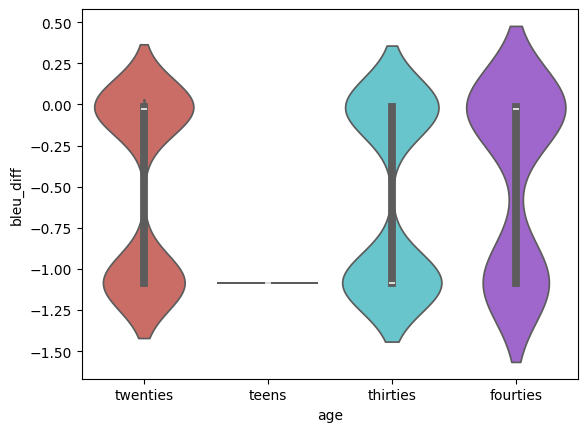

  quantile      mean       var       max       min
0       Q1  0.514356  0.007382  0.612687  0.000000
1       Q2  0.568938  0.009143  0.692428  0.205048
2       Q3  0.608023  0.015769  0.783560  0.330355
3       Q4  0.700570  0.033027  1.000000  0.387313


In [47]:
from scipy.stats import shapiro, levene
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'testresults/testresult - 0.csv'

df = prepocess_for_vanlysis(file_path)

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

x_var = 'age'
y_var = 'bleu_diff'

# remove missing value
df = df.dropna(subset=[x_var, y_var])

# anonva
model = ols(f'{y_var} ~ C({x_var})', data=df).fit()
anova_table = anova_lm(model)
print(anova_table)
print(anova_table.iloc[0,-1])

# nomality
stat, p = shapiro(df[y_var])
print(f'Shapiro-Wilk Test: statistic={stat}, p-value={p}')

# homoscedasticity (variance)
groups = [group[y_var].dropna() for _ , group in df.groupby('age')]
stat, p = levene(*groups)
print(f'Levene Test: statistic={stat}, p-value={p}')

avg_df = df.groupby(x_var)[y_var].agg(['mean','var']).reset_index()

print(avg_df)

# viloin plot
fig, ax = plt.subplots()
sns.violinplot(x=x_var, y=y_var, data=df , 
               palette = sns.color_palette("hls", len(df[x_var].unique())),ax=ax)
plt.show()

df.groupby('age')


# 'setence_len'의 사분위수를 계산합니다.
quantiles = df['sentence_len'].quantile([0.25, 0.5, 0.75])

# 각 사분위수에 해당하는 'bleu' 값들을 찾습니다.
bleu_values_q1 = df.loc[df['sentence_len'] <= quantiles[0.25], 'bleu_diff']
bleu_values_q2 = df.loc[(df['sentence_len'] > quantiles[0.25]) & (df['sentence_len'] <= quantiles[0.5]), 'bleu_diff']
bleu_values_q3 = df.loc[(df['sentence_len'] > quantiles[0.5]) & (df['sentence_len'] <= quantiles[0.75]), 'bleu_diff']
bleu_values_q4 = df.loc[df['sentence_len'] > quantiles[0.75], 'bleu_diff']

# 각 사분위수에 해당하는 'bleu' 값들의 평균, 분산, 최대, 최소를 계산합니다.
summary_df = pd.DataFrame({
    'quantile': ['Q1', 'Q2', 'Q3', 'Q4'],
    'mean': [bleu_values_q1.mean(), bleu_values_q2.mean(), bleu_values_q3.mean(), bleu_values_q4.mean()],
    'var': [bleu_values_q1.var(), bleu_values_q2.var(), bleu_values_q3.var(), bleu_values_q4.var()],
    'max': [bleu_values_q1.max(), bleu_values_q2.max(), bleu_values_q3.max(), bleu_values_q4.max()],
    'min': [bleu_values_q1.min(), bleu_values_q2.min(), bleu_values_q3.min(), bleu_values_q4.min()],
})

print(summary_df)



In [17]:
file_path = 'testresults/testresult - 0.csv'
from scipy.stats import ttest_ind
df = prepocess_for_vanlysis(file_path)

# sentence_len의 중앙값을 기준으로 두 그룹으로 나눕니다.
median_sentence_len = df['sentence_len'].median()
group1 = df[df['sentence_len'] <= median_sentence_len]
group2 = df[df['sentence_len'] > median_sentence_len]

# 각 그룹에서 i_blue와 blue의 평균 차이를 계산합니다.
mean_diff_group1 = group1['i_bleu'].mean() - group1['bleu'].mean()
mean_diff_group2 = group2['i_bleu'].mean() - group2['bleu'].mean()

# 두 그룹의 평균 차이가 통계적으로 유의미한지 확인합니다.
t_stat, p_val = ttest_ind(group1['i_bleu'] - group1['bleu'], group2['i_bleu'] - group2['bleu'])

print(f"Group 1 mean difference: {mean_diff_group1}")
print(f"Group 2 mean difference: {mean_diff_group2}")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")



pd.DataFrame(df.groupby('style')['i_bleu'].mean() - df.groupby('style')['bleu'].mean(), columns=['diff'])




Group 1 mean difference: -0.5964074787840004
Group 2 mean difference: -0.5464952134506752
T-statistic: -1.2553323707707593
P-value: 0.20976595668638334


,diff
style,
spoken,-0.591821
written,0.015250


In [ ]:
from scipy.stats import ttest_ind
import numpy as np



In [125]:
import math

pdf = prepocess_for_vanlysis('testresults/testresult - 0.csv')
cdf = prepocess_for_vanlysis('testresults/testresult - 1.csv')


'''
make a fake data frame with the below structure

[colum structure]
1st              : fcol_name with fcol_values
2nd ~ (last - 1) : columns ← random number generated
last             : some calculateion with the middle position columns, 
                   currently 'diff' (last - first) at the middle position column

: param fcol_name   : the name of first column
: param fcol_values : the values assigned to the first column
: param columns     : the name of middle position columns whose values are assgined with random
: param make_last   : if True, make a special column for a given calcuation type
: param type_last   : currentl diff only supported
                    : last column value - first colum value in the given columns
'''
def random_dataframe(fcol_name:str, fcol_values:List[str], 
                     columns:List[str], make_last:bool = False, type_last:str = '') -> pd.DataFrame:
    
    columns.insert(0, fcol_name)
    if(make_last & (len(columns) > 1)):
        columns.append(type_last)
    
    rdf = pd.DataFrame(columns = columns)
        
    for r_idx, fcol_val in enumerate(fcol_values):
        # dictionary to fill into a raw
        tmp = {}
        # from the first to the last
        for c_idx, col in enumerate(columns):
            if c_idx == 0:
                tmp[col] = fcol_val
            else:
                tmp[col] = np.random.normal(0.5, 0.3)
        # last column
        if(make_last & (len(columns) > 1)):
            tmp[columns[-1]] = tmp[columns[1]] - tmp[columns[-1]] 
            
        # fill into this raw
        rdf.loc[r_idx] = tmp
    
    return rdf

#
# Language Dataframe for ASR
#
codes = ['KR', 'EN', 'ES', 'FR', 'DE', 'IT', 'JP', 'CN', 'RU', 'PT', 
         'AR', 'HI', 'SW', 'NL', 'SV', 'PL', 'TR', 'TH', 'HE', 'DA']
ldf = random_dataframe(fcol_name='lang',
                       fcol_values = codes,
                       columns=['wer_c', 'wer_p'],
                       make_last=True,
                       type_last='diff')
ldf.loc[0, ['wer_c']] = cdf['wer'].mean()
ldf.loc[0, ['wer_p']] = pdf['wer'].mean()
ldf.loc[0, ['diff']] = cdf['wer'].mean() - pdf['wer'].mean()


#
# Utterance Dataframe for ASR
# - after dropping missing value
#
columns = cdf['sentence_len_type'].dropna().unique().tolist()
udf = random_dataframe(fcol_name='lang',
                       fcol_values = codes,
                       columns = columns)
for col in columns[1:]:
    udf.loc[0, [col]] = cdf.groupby('sentence_len_type')['wer'].mean()[col]

#
# Age Dataframe for ASR
# - after dropping missing value
#
columns = cdf['age'].dropna().unique().tolist()
adf = random_dataframe(fcol_name='lang',
                       fcol_values = codes,
                       columns = columns)
for col in columns[1:]:
    adf.loc[0, [col]] = cdf.groupby('age')['wer'].mean()[col]

#
# Gender Dataframe for ASR
# - after dropping missing value
#
columns = cdf['gender'].dropna().unique().tolist()
gdf = random_dataframe(fcol_name='lang',
                       fcol_values = codes,
                       columns = columns)
for col in columns[1:]:
    gdf.loc[0, [col]] = cdf.groupby('gender')['wer'].mean()[col]

#
# Style Dataframe for ASR
# - after dropping missing value
#
columns = cdf['style'].dropna().unique().tolist()
sdf = random_dataframe(fcol_name='lang',
                       fcol_values = codes,
                       columns = columns)
for col in columns[1:]:
    sdf.loc[0, [col]] = cdf.groupby('style')['wer'].mean()[col]


In [144]:
import seaborn as sns
from statsmodels.formula.api import ols
from scipy.stats import pearsonr, shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from typing import List, Tuple, Any


# chart creation and statstic analysis for two numerical variable
# - scatter plot :  
# - pearson correlation , regression anlaysis 
def v_analyze_numerics(df:pd.DataFrame , x_var:str, y_var:str) -> Tuple[Any, List[str]]:
    # strings to display
    ret = []
    
    # pearson analysis
    correlation, p_value = pearsonr(df[x_var], df[y_var])
    ret.append(f'### pearson : coefficient ({correlation}) with p-value({p_value})')
    ret.append(f"    * {x_var} normality (shapiro-wilk): {shapiro(df[x_var])[1]}")
    ret.append(f"    * {y_var} normality (shapiro-wilk): {shapiro(df[y_var])[1]}")

    # regression analysis
    model = ols(f'{y_var} ~ {x_var}', data = df).fit()
    ret.append(f'### regression : coefficient ({model.params[0]}) with p-value({model.f_pvalue})')
    ret.append(f"    * residual nomality (shaprio-wilk): {shapiro(model.resid)[1]}")
    ret.append(f"    * residual homogeneity of variances (breusch-pagan) : {het_breuschpagan(model.resid, model.model.exog)[1]}")
    
    return sns.scatterplot(x = x_var, y = y_var, data = df) , ret


In [184]:
file_path = 'testresults/testresult - 1.csv'
df = prepocess_for_vanlysis(file_path)
df.columns
x_var = 'gender'
y_var = 'wer'


df.columns

f'{y_var} ~ ' + ' + '.join(df.filter(regex=f'^{x_var}_').columns)



'wer ~ gender_female + gender_male'

/tmp/ipykernel_14361/3989998548.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=x_var, y=y_var, data=df , palette = sns.color_palette("hls", len(df[x_var].unique())))
/tmp/ipykernel_14361/3989998548.py:16: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.violinplot(x=x_var, y=y_var, data=df , palette = sns.color_palette("hls", len(df[x_var].unique())))


['# anova : 0.0007237416355624133 with 0.0007237416355624133',
 '  * shaprio : ShapiroResult(statistic=0.8763274550437927, pvalue=1.776783602354218e-23)',
 '  * breusch-pagan : (222.98353412304527, 3.7996254465828485e-49, 160.73984342909566, 2.049882641679326e-58)']

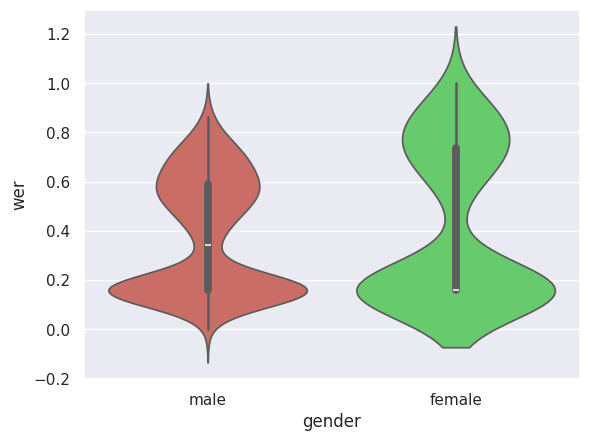

In [199]:
#
# 범주형 변수들에 대한 시각화 및 검정
#
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import seaborn as sns

x_var = 'gender'
y_var = 'wer'
df = df

'''
'''
def v_analyze_categorics(df:pd.DataFrame , x_var:str, y_var:str) -> Tuple[Any, pd.DataFrame, List[str]]:
    ret = []

    # display statistical analysis result
    # 1) average for each category
    avg_df = pd.DataFrame(df.groupby(by=x_var)[y_var].mean())

    # 2) analysis of variance
    # fit regression model
    formula = f'{y_var} ~ ' + ' + '.join(df.filter(regex=f'^{x_var}_').columns)
    model = ols(formula, data = df).fit()
    # one way anova and extract p-value from the result
    p_val = anova_lm(model).iloc[0,-1]

    ret.append(f'# anova : {p_val} with {p_val}')
    ret.append(f"  * shaprio : {shapiro(model.resid)}")
    ret.append(f"  * breusch-pagan : {het_breuschpagan(model.resid, model.model.exog)}")
    
    return sns.violinplot(x=x_var, y=y_var, data=df , palette = sns.color_palette("hls", len(df[x_var].unique()))), avg_df, ret

/tmp/ipykernel_14361/3867170143.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='style', y='wer', data=df , palette=palette)


,wer
style,
spoken,0.540512
written,0.294189


2.4984788464270706e-24

True

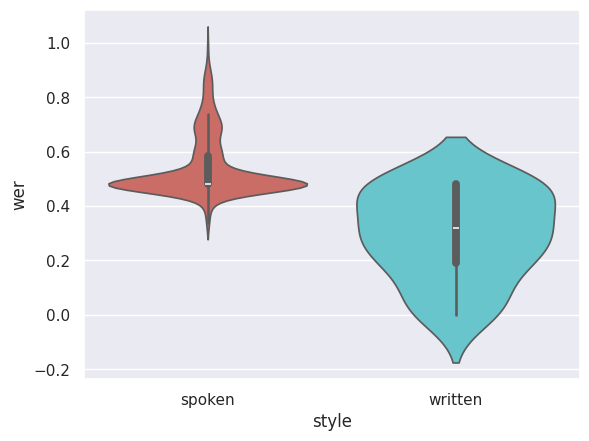

In [96]:
# violin plot
import seaborn as sns

# display on the chart area
sns.set(color_codes = True)
palette = sns.color_palette("hls", len(df['style'].unique()))
sns.violinplot(x='style', y='wer', data=df , palette=palette)

# display on the expander : average difference table
display(pd.DataFrame(df.groupby(by='style')['wer'].mean()))

# display on the expander 
# - significally significant or not : p-value & TRUE or FALSE 
# - using one way anova
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
model = ols('wer ~ n_style', data =df).fit()
p_val = anova_lm(model).iloc[0,-1]
display(p_val , p_val < 0.05)


In [39]:
import pandas as pd

df = pd.read_csv('./testresults/testresult - 4.csv')

df = df.drop(columns=['Unnamed: 0','ref']).drop_duplicates()

len(df)


721

In [51]:
# 문체
df.accents.value_counts()
df['sentence_style'] = df['accents'].apply(lambda x: 'written' if x == 'reading book' else 'spoken')
df['sentence_style'].value_counts(dropna=False)

sentence_style
spoken     698
written     23
Name: count, dtype: int64

In [42]:
# 문장길이
# 장문 : 3사분위수 초과
# 중문 : 1사분위수 ~ 3사 분위수
# 단문 : 1사분위수 미만
df['sentence_len'] = df['sentence'].str.len()
q1 = df.sentence_len.quantile(q = 0.25) 
q3 = df.sentence_len.quantile(q = 0.75)
df['sentence_len_type'] = df['sentence_len'].apply(lambda x: 'long' if x > q3 else ('short' if x < q1 else 'middle'))
df.sentence_len_type.value_counts(dropna=False)

sentence_len_type
middle    376
long      177
short     168
Name: count, dtype: int64

In [49]:
df['gender'] = df['gender'].fillna('Unknown')
df['gender'].value_counts(dropna=False)

gender
male       484
female     141
Unknown     96
Name: count, dtype: int64

In [50]:
df['age'].value_counts(dropna=False)
df['age'] = df['age'].replace({'teens':'10s', 'twenties':'20s', 'thirties':'30s', 'fourties':'40s'})
df['age'] = df['age'].fillna('Unknown')
df['age'].value_counts(dropna=False)

age
20s        317
30s        235
Unknown     96
40s         50
10s         23
Name: count, dtype: int64

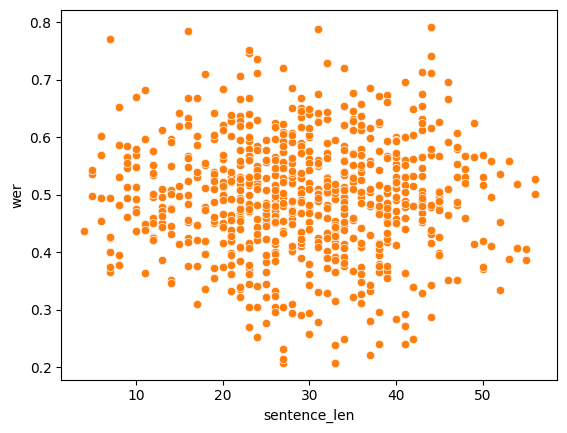

In [123]:
dfa = df.groupby(['sentence_style'])[['wer']].mean().T
dfb = df.groupby(['sentence_len_type'])[['wer']].mean().T
dfc = df.groupby(['gender'])[['wer']].mean().T
dfd = df.groupby(['age'])[['wer']].mean().T

# dfc = pd.concat([dfa, dfb], axis=1)

# dfc
dfe = pd.concat([dfa.reset_index(drop=True), 
                 dfb.reset_index(drop=True),
                 dfc.reset_index(drop=True),
                 dfd.reset_index(drop=True)], axis=1).reset_index(drop=True)

# dfe.index = ['한국어', '영어', '중국어']
# dfe.loc['영어':, :] = np.nan

dfe
# dfc.columns = pd.MultiIndex.from_tuples([('style', col) if i < 2 else ('len', col) for i, col in enumerate(dfc.columns)])
# dfc

# 입력 언어 , 출력 언어를 추가해야 함
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# sns.violinplot(data=df['wer'])

# plt.show()
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x='sentence_len', y='wer', data=df)
plt.show()

In [182]:
from typing import Tuple,List

cdf = prepocess_for_vanlysis('testresults/testresult - 1.csv')

cdf.sentence_len.max(), cdf.sentence_len.min()

# return : sentence, transcript, path

print(cdf.columns)
# sentence_len
aspect_name = 'sentence_len'
metric_name = 'wer'
aspect_max = 20
aspect_min = 10
metric_max = 1.0
metric_min = 0.1
ret_columns= ['sentence','transcript', 'path']

def get_testresults_by_numeric(aspect_name:str, aspect_max:float, aspect_min:float, 
                               metric_name:str, metric_max:float, metric_min:float,
                               ret_columns:List[str]) -> List[List[str]]:
    condition1 = (cdf[aspect_name] >= aspect_min) & (cdf[aspect_name] <= aspect_max)
    condition2 = (cdf[metric_name] <= metric_max) & (cdf[metric_name] >= metric_min)
    
    ret = []
    for i, ret_col in enumerate(ret_columns):
        ret.append(cdf[condition1 & condition2][ret_col])

    return ret

get_testresults_by_numeric(aspect_name, aspect_max, aspect_min, metric_name, metric_max, metric_min, ret_columns)


Index(['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'accents',
       'variant', 'locale', 'segment', 'transcript', 'sentence_len', 'wer',
       'bleu', 'i_bleu', 'sentence_len_type', 'age_fourties', 'age_teens',
       'age_thirties', 'age_twenties', 'style_spoken', 'style_written',
       'gender_female', 'gender_male', 'age', 'style', 'gender'],
      dtype='object')


[133        그는 담 밑에 착 붙어 섰다.
 134    사랑은 말이지, 소유하는 게 아니야.
 143       국가는 국가표준제도를 확립한다.
 165            나는 아무 걱정도 없이
 166        평안도 어느 산 깊은 금덤판.
 174     그래봐야 아무것도 얻을 것이 없다.
 177            슬기론 인민의 이 영광
 188            실행할 당연한 일이건만
 189          세 살 버릇 여든까지 간다
 190    비 맞은 나뭇가지 새 움이 뾰죽뾰죽.
 317        난 집에 들어가자마자 체포됐어
 417            백두산 기상을 다 안고
 419      이마와 뺨에 입을 맞추어 주었다.
 422    투표 방법에 대해서 설명드리겠습니다.
 432           달이라고는 이름 뿐이요.
 433        그는 제게 햇빛이고 공기였어요
 443          네 생각은 네 말이 된다.
 460      돈 있으면 양반이지 별게 있느냐!
 492             찬란한 문화로 자라난
 518            옷 그렇게 벗지 말라고
 523       병원에만 계속 있으면 병납니다.
 528      대한 사람 대한으로 길이 보전하세
 534      실상인즉 뻔히 섰던 것이 아니라.
 543          그들은 나에게 힘을 준다.
 545    그는 그와 한 학급에 있는 인호였다.
 548        제가 지금 좀 너무 급해서요.
 549           우리 마누라가 죽었다네.
 560        목요일에 게임을 하시겠습니까?
 565    여동생이 점점 어머니를 닮았나 보다.
 572    자, 여기 어떤 상점이 있다 합시다.
 577     스스로 묻기도 하고 한숨도 짓는다.
 586          몸과 맘 다 바쳐 이 조선
 592       아씨, 인력거 아니 타시랍시요?
 594     야, 넌 말 좀 고상하게 못 하냐?
 599       진짜 

In [ ]:

# age
metric_name = 'wer'
aspect_name = 'age'
aspect_values = ['twenties', 'thirties']
metric_max = 1.0
metric_min = 0.1

condition1 = False
for aval in aspect_values:
    condition1 = condition1 | (cdf[aspect_name] == aval)
cdf[condition1][aspect_name]
condition2 = (cdf[metric_name] <= metric_max) & (cdf[metric_name] >= metric_min)
cdf[condition1 & condition2].loc[:, [metric_name, aspect_name,'sentence', 'transcipt', 'path']]